# 개요

이 프로젝트는 중국 광저우의 부녀아동의료센터가 후향적 코호트 연구로 진행한 1-5세 소아 환자의 흉부 엑스레이 사진으로부터, 환자의 폐렴 병증 유무를 감지하는 이미지 분석 딥러닝 모델을 만드는 작업이다.

# 목차

1. 코드 작성
- 패키지 및 데이터 로드
- 데이터 전처리
- 모델링 및 훈련

2. 사례 분석
- \[Case 1\] Resnet-18 가중치 조정 여부에 따른 성능 비교
- \[Case 2\] Resnet-18 하이퍼 파라미터 조정에 따른 비교

# 1. 코드 작성

## 라이브러리 및 설정 불러오기

### 사용할 패키지 불러오기

In [1]:
import re
import os
import random, math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 데이터 경로 및 상수 설정

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

In [3]:

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
print(ROOT_PATH)

/aiffel/aiffel


## 데이터 전처리

### 데이터 병합 및 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
# 파일명 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


### 하이퍼 파라미터 정의

In [8]:
# 전역변수

BATCH_SIZE = 16
EPOCHS = 10

### 배치, 레이블링, 변환

In [9]:
# 파일명을 이용한 데이터 라벨 생성 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 처리가능한 형태로 이미지 형식 변경 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 형식 및 라벨 처리 함수
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

# tf.data 파이프라인을 이용한 효율적 데이터 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 버퍼 크기에 맞게 무작위로 다음 항목 선정
    ds = ds.repeat() # 데이터셋 로드 이터레이션 크기 자동화
    ds = ds.batch(BATCH_SIZE) # 훈련 이터레이션 자동화
    ds = ds.prefetch(buffer_size=AUTOTUNE) # CPU/GPU 가용 최적화
    return ds

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [10]:
# tf.data 패키지를 활용한 미니 배치(적절한 배치 규모를 선택하는 방법)
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
# 훈련/검증 데이터셋 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 데이터셋 생성 여부 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# 테스트 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# 데이터 증강 시도시 커널 작동이 멈추는 문제가 발생
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

In [15]:
# 데이터셋 훈련준비
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [16]:
# 훈련셋 이미지 갯수 지정
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 준비된 이미지 배치 출력

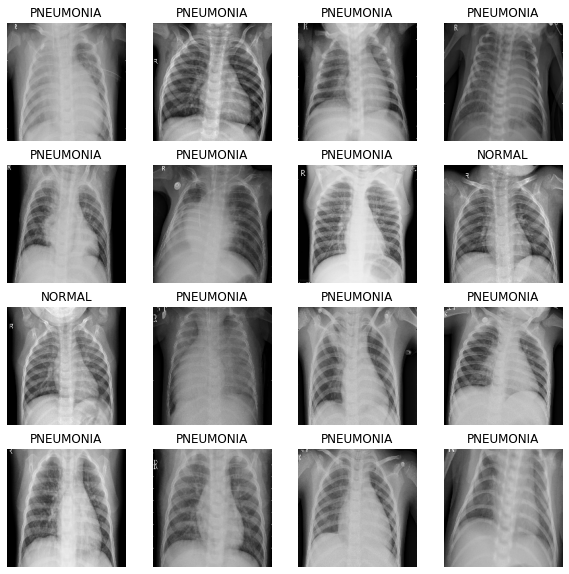

In [17]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 모델링 및 훈련

### ResNet-18 모델링 함수 정의

In [18]:
# 잔차(Residual) 블록
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    # 1st conv layer in the block
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # 2nd conv layer in the block
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Adjusting the shortcut for addition if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    
    x = tf.keras.layers.Add()([shortcut, x])
    x = tf.keras.layers.ReLU()(x)
    
    return x

In [19]:
# ResNet-18 빌드
def build_resnet18(input_shape):
    input = tf.keras.Input(shape=input_shape)
    
    # Initial Conv layer
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # ResNet layers
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layer (In this case for binary classification)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input, outputs=output)
    return model

In [20]:
def build_model():
    model = build_resnet18((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    return model

# 2. 사례 분석

## [Case 1] Resnet-18 가중치 조정 여부에 따른 성능 비교


### 가중치 조정 여부에 따른 모델 훈련 결과 비교

In [21]:
# 가중치 조정(Weight Balancing) 기법을 통한 데이터 불균형 처리
# 케라스 fit 메서드에 사용할 하이퍼 파라미터 class_weight 정의

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [22]:
# 모델 컴파일 함수 정의
def compile_model(model):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    return model

# 훈련 함수 정의
def train_model(model, use_class_weight=False):
    with tf.device('/GPU:0'):
        if use_class_weight:
            history = model.fit(
                train_ds,
                steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=val_ds,
                validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                class_weight=class_weight,
            )
        else:
            history = model.fit(
                train_ds,
                steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=val_ds,
                validation_steps=VAL_IMG_COUNT // BATCH_SIZE
            )
    return history

In [23]:
# 첫 번째 시나리오: class_weight 사용하지 않음
model_without_weight = build_model()
model_without_weight = compile_model(model_without_weight)
history_without_weight = train_model(model_without_weight)

# 두 번째 시나리오: class_weight 사용
model_with_weight = build_model()
model_with_weight = compile_model(model_with_weight)
history_with_weight = train_model(model_with_weight, use_class_weight=True)

Epoch 1/10
261/261 [==============================] - 67s 206ms/step - loss: 0.3117 - accuracy: 0.9011 - precision: 0.9266 - recall: 0.9418 - val_loss: 2.2746 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 202ms/step - loss: 0.1590 - accuracy: 0.9404 - precision: 0.9568 - recall: 0.9633 - val_loss: 0.5235 - val_accuracy: 0.7923 - val_precision: 0.7791 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 208ms/step - loss: 0.1190 - accuracy: 0.9593 - precision: 0.9703 - recall: 0.9752 - val_loss: 0.7516 - val_accuracy: 0.7962 - val_precision: 0.7828 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.0962 - accuracy: 0.9641 - precision: 0.9747 - recall: 0.9772 - val_loss: 0.0979 - val_accuracy: 0.9721 - val_precision: 0.9693 - val_recall: 0.9935
Epoch 5/10
261/261 [==============================] - 52s 200ms/step - loss: 0.0922 - accura

### 결과 확인

39/39 [==============================] - 5s 115ms/step - loss: 0.7643 - accuracy: 0.7324 - precision: 0.9025 - recall: 0.6410
With Class Weight - Loss: 0.7643409371376038, Accuracy: 0.7323718070983887, Precision: 0.9025270938873291, Recall: 0.6410256624221802
39/39 [==============================] - 5s 118ms/step - loss: 11.5038 - accuracy: 0.3958 - precision: 0.9333 - recall: 0.0359
Without Class Weight - Loss: 11.503764152526855, Accuracy: 0.3958333432674408, Precision: 0.9333333373069763, Recall: 0.03589743748307228


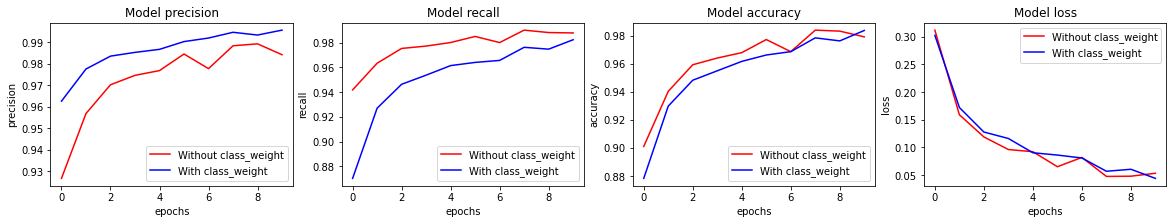

In [24]:
# 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

metrics_list = ['precision', 'recall', 'accuracy', 'loss']
for i, met in enumerate(metrics_list):
    ax[i].plot(history_without_weight.history[met], 'r', label='Without class_weight')
    ax[i].plot(history_with_weight.history[met], 'b', label='With class_weight')
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend()

# 값 출력
loss, accuracy, precision, recall = model_with_weight.evaluate(test_ds)
print(f'With Class Weight - Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
loss, accuracy, precision, recall = model_without_weight.evaluate(test_ds)
print(f'Without Class Weight - Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

### 분석

(1) 손실함수와 정확도 측면에서는 가중치 조정 기법 적용이 큰 영향을 미치지 않는 것으로 보인다.
(2) 다만 정밀도에서는 가중치를 조정한 것이, 재현율에서는 가중치를 손보지 않은 것이 더 효과적으로 나타났다.

(2)의 문제에 관해서 생각해보면, 폐렴에 대한 예측치는 가중치를 조정한 것이 높지만 전체 재현율에서 폐렴이 아닌 경우를 폐렴이라고 진단하였을 가능성이 높다는 추정이 가능하다.

유병자를 확인하는 것이 더 중요하므로, 가중치 조정을 수행한 모델에 대해서 추가적인 모델 개선작업을 수행한다.

## [Case 2] Resnet-18 하이퍼 파라미터 조정에 따른 비교